### Описание задачи

Из нейросети получены данные о заруженности в виде количества машин на перекрестке.
Задача спрогнозировать количество траффика в нужный момент времени

### Импорты

In [ ]:
# pip install ephem

In [198]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
import ephem

### Генерация данных

In [246]:


# Set the desired date range
start_date = '2023-01-01'
end_date = '2023-12-31'

# Generate a date range with hourly frequency
date_range = pd.date_range(start=start_date, end=end_date, freq='H')


# Generate data with higher car counts during peak hours on working days
data = {
    'date': date_range,
    'number_of_cars': [
        np.random.randint(50, 100) if ((date.hour  in range(7,10) or date.hour in range (17,20)) and date.weekday() <6) else np.random.randint(0, 50)
        for date in date_range
    ]
}

df = pd.DataFrame(data)

# Convert the 'date' column to datetime index
df.set_index('date', inplace=True)




In [247]:


def generate_temperature(date):
    observer = ephem.Observer()
    observer.lat = '45.0355'  # Latitude of Krasnodar, Russia
    observer.date = date

    sunrise = observer.previous_rising(ephem.Sun()).datetime()
    sunset = observer.next_setting(ephem.Sun()).datetime()

    temperature_range = {
        'spring': (-5, 20),    # Temperature range for spring
        'summer': (20, 35),    # Temperature range for summer
        'autumn': (5, 20),     # Temperature range for autumn
        'winter': (-5, 10)     # Temperature range for winter
    }

    if sunrise < date < sunset:  # Daytime temperature
        if 80 <= date.timetuple().tm_yday <= 171:  # Spring
            return np.random.randint(*temperature_range['spring'])
        elif 172 <= date.timetuple().tm_yday <= 264:  # Summer
            return np.random.randint(*temperature_range['summer'])
        elif 265 <= date.timetuple().tm_yday <= 355:  # Autumn
            return np.random.randint(*temperature_range['autumn'])
        else:  # Winter
            return np.random.randint(*temperature_range['winter'])
    else:  # Nighttime temperature
        return np.random.randint(-10, 5)  # Assume slightly colder temperature during nighttime

# Add temperature column to the dataframe
df['temperature'] = [generate_temperature(date) for date in df.index]


### Вcпомогательные функции

In [260]:
df.to_csv('traffic_prediction.csv')

In [201]:
def make_features(data, max_lag, rolling_mean_size):
    """makes additional features for timeseries dataset"""
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for i in range(1, max_lag + 1):
        column_name = "lag_" + str(i)
        data[column_name] = data['number_of_cars'].shift(i)
    data['rolling_mean'] = data['lag_1'].rolling(rolling_mean_size).mean()
    
    return data


### Разделение выборки на тренировочную и тестовую

Применяем специальный сплит для временных рядов, чтобы не было утечки данных

In [202]:
tscv = TimeSeriesSplit(n_splits=5)
scoring_metric='neg_mean_squared_error'

In [218]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    lag_cols = []
    new_data = pd.DataFrame()
    for i in range(1, max_lag + 1):
        column_name = "lag_" + str(i)
        new_data[column_name] = data['number_of_cars'].shift(i)
        lag_cols.append(column_name)
    
    data = pd.concat([data, new_data], axis=1)
    data['rolling_mean'] = data[lag_cols].rolling(rolling_mean_size).mean().values[:, -1]
    
    return data

### Машинное обучение


In [219]:
best_rmse = 60
lag = 0
window = 0



for i in range(5, 100, 5):
    for k in range(2, 50, 5):
        data = df.copy(deep=True)
        make_features(data, i, k)
        data = data.dropna()
        target = data['number_of_cars']
        features = data.drop(['number_of_cars'], axis=1)
        
        model_lin_regression = LinearRegression()
        scores = cross_val_score(model_lin_regression, features, target, cv=tscv, scoring=scoring_metric)
        rmse = np.sqrt(np.abs(np.mean(scores)))
        
        if rmse < best_rmse:
            best_rmse = rmse
            lag = i
            window = k

print('Best RMSE:', best_rmse)
print('Lag:', lag)
print('Window:', window)


Best RMSE: 25.030001910359562
Lag: 5
Window: 2


In [220]:


best_rmse = 60
lag = 0
window = 0

for i in range(5, 100, 5):
    for k in range(2, 50, 5):
        data = df.copy(deep=True)
        make_features(data, i, k)
        data = data.dropna()
        target = data['number_of_cars']
        features = data.drop(['number_of_cars'], axis=1)
        
        model_lgbm = lgb.LGBMRegressor()
        scores = cross_val_score(model_lgbm, features, target, cv=tscv, scoring=scoring_metric)
        rmse = np.sqrt(np.abs(np.mean(scores)))
        
        if rmse < best_rmse:
            best_rmse = rmse
            lag = i
            window = k

print('Best RMSE:', best_rmse)
print('Lag:', lag)
print('Window:', window)


Best RMSE: 15.139972198124783
Lag: 5
Window: 2


Сохраним модель

In [233]:
data = df.copy(deep=True)
make_features(data, lag, window)
data = data.dropna()
target = data[['number_of_cars']]
features = data.drop(['number_of_cars'], axis=1)
model_lgbm = lgb.LGBMRegressor()
model_lgbm.fit(features,target)

LGBMRegressor()

In [222]:
data

,date,temperature
0,2023-07-01,18


In [259]:
import pandas as pd

# Create a DataFrame with the desired date and temperature


np.random.seed(0)
temperatures = np.random.randint(10, 30, size=24)

# Create a DataFrame with the generated temperatures
data = pd.DataFrame({
    'temperature': temperatures
}, index=pd.date_range('2024-07-02 00:00:00', periods=24, freq='H'))

# Convert the index to datetime format
data.index = pd.to_datetime(data.index)

data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek

# Make predictions using your trained model

# Drop the 'number_of_cars' column from the new data
features = data

# Make predictions using your trained model
predictions = model_lgbm.predict(features)

# Add the predictions to the data DataFrame
data['predictions'] = predictions

data




,temperature,year,month,day,hour,dayofweek,predictions
2024-07-02 00:00:00,22,2024,7,2,0,1,22.187373
2024-07-02 01:00:00,25,2024,7,2,1,1,25.065182
2024-07-02 02:00:00,10,2024,7,2,2,1,23.444851
2024-07-02 03:00:00,13,2024,7,2,3,1,27.069087
2024-07-02 04:00:00,13,2024,7,2,4,1,26.673440
2024-07-02 05:00:00,17,2024,7,2,5,1,27.003790
2024-07-02 06:00:00,19,2024,7,2,6,1,26.465845
2024-07-02 07:00:00,29,2024,7,2,7,1,76.726729
2024-07-02 08:00:00,28,2024,7,2,8,1,74.814938
2024-07-02 09:00:00,14,2024,7,2,9,1,77.443467


In [244]:
import pickle


with open('traffic_forecast_model', 'wb') as f:
    pickle.dump(model_lgbm, f)


In [245]:
with open('traffic_forecast_model', 'rb') as f:
    loaded_model = pickle.load(f)

### Выводы

1. Можем улучшать качество модели за счет подбора гиперпараметров

2. Можем улучшать качество модели за счет добавления новых признаков

3. В дальнейшем при добавлении данных с других соседних перекрестков, мы можем использовать более сложные алгоритмы 

  Autoregressive Integrated Moving Average (ARIMA), 

  Seasonal ARIMA (SARIMA), 

  and Exponential Smoothing (ETS) models 


4. Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks, по мере добавления данных с новых перекрестков


5.Подключение api погоды 

In [84]:
import matplotlib.pyplot as plt

def plot_traffic_for_day(df, date):
    # Filter the dataframe for the given date
    day_data = df[date.date()]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(day_data.index, day_data['number_of_cars'], color='blue')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Cars')
    ax.set_title(f'Traffic Data for {date.date()}')
    ax.grid(True)

    # Set the x-axis tick frequency to show hours
    ax.xaxis.set_major_locator(plt.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(plt.DateFormatter('%H:%M'))

    # Rotate the x-axis tick labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [106]:
df

,number_of_cars
date,
2023-01-01 00:00:00,18
2023-01-01 01:00:00,26
2023-01-01 02:00:00,35
2023-01-01 03:00:00,9
2023-01-01 04:00:00,37
...,...
2023-12-30 20:00:00,27
2023-12-30 21:00:00,5
2023-12-30 22:00:00,7


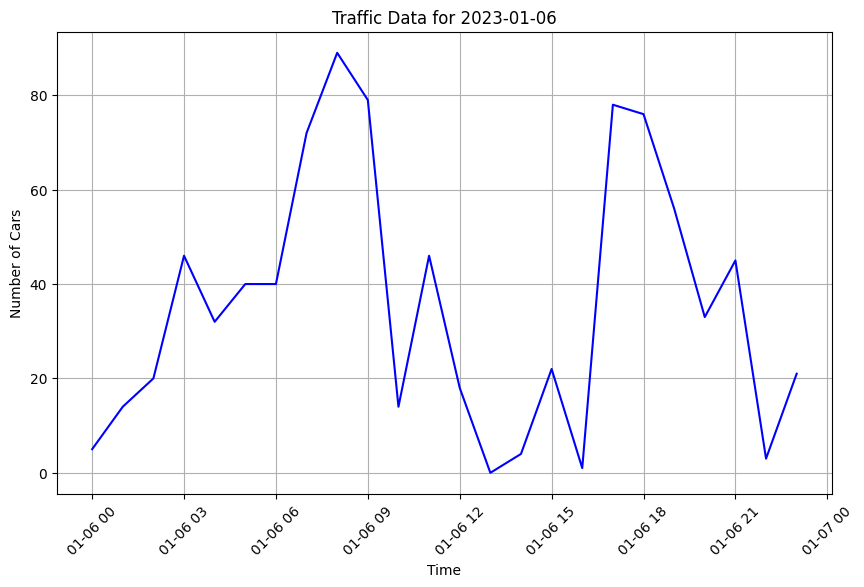

In [164]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_traffic_for_day(df, date_str):
    # Convert date string to datetime object
    date = datetime.strptime(date_str, '%Y-%m-%d')

    # Filter the dataframe for the given date
    day_data = df[df.index.date == date.date()]

    # Plotting code...
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(day_data.index, day_data['number_of_cars'], color='blue')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Cars')
    ax.set_title(f'Traffic Data for {date.date()}')
    ax.grid(True)

    # Set the x-axis tick frequency to show hours

 
    # Rotate the x-axis tick labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

# Call the function with the correct date format



График загрузки дороги, понедельник


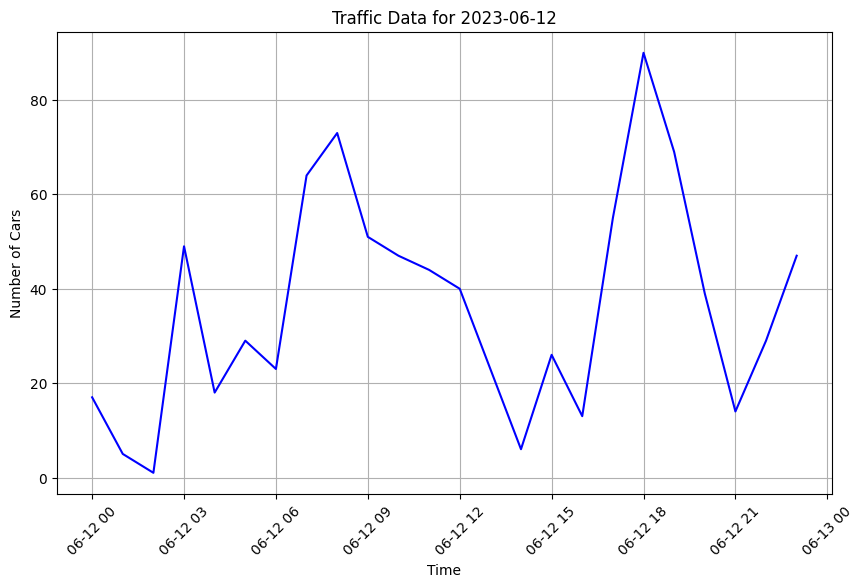

In [168]:
print('График загрузки дороги, понедельник')
plot_traffic_for_day(df, '2023-06-12')

#Количесто людей на остановке